<h1><center>Basics of Algorithmic Trading</center></h1>

# Strategies Based on Mean Reversion

While (time series) momentum strategies assume a positive correlation between returns, mean-reversion strategies assume a negative correlation. In layman terms, if a financial instrument has performed “too well” relative to its trend, it is shorted, and vice versa. 

# Setup

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="darkgrid")

# Read the data from local drive

In [2]:
data = pd.HDFStore('data/BitcoinPriceData.h5', 'r')

dataMeanReversion = data['BitcoinPriceData']

data.close()

print(dataMeanReversion.info())
print('-'*20)
print('-'*20)
print(dataMeanReversion.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2016-01-01 to 2021-06-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1980 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB
None
--------------------
--------------------
               Value
Date                
2021-05-29  35689.62
2021-05-30  34647.67
2021-05-31  35684.59
2021-06-01  37310.54
2021-06-02  36662.64


In [3]:
dataMeanReversion.rename(columns={'Value':'price'}, inplace=True)

# Mean Reversion

Let's make an algorithm that follows this ideology.

In [4]:
dataMeanReversion = dataMeanReversion[1700:]

In [5]:
# Returns.
dataMeanReversion['returns'] = np.log(dataMeanReversion['price'] / dataMeanReversion['price'].shift(1))

# Rolling window size.
wnd_sz_mr = 7

# Simple moving average.
dataMeanReversion['SMA'] = dataMeanReversion['price'].rolling(wnd_sz_mr).mean()

dataMeanReversion.dropna(inplace=True)

In [6]:
# Threshold to identify an abnormality in price.
threshold = 4000

# Amount of fluctuation from the moving average.
dataMeanReversion['distance'] = dataMeanReversion['price'] - dataMeanReversion['SMA']

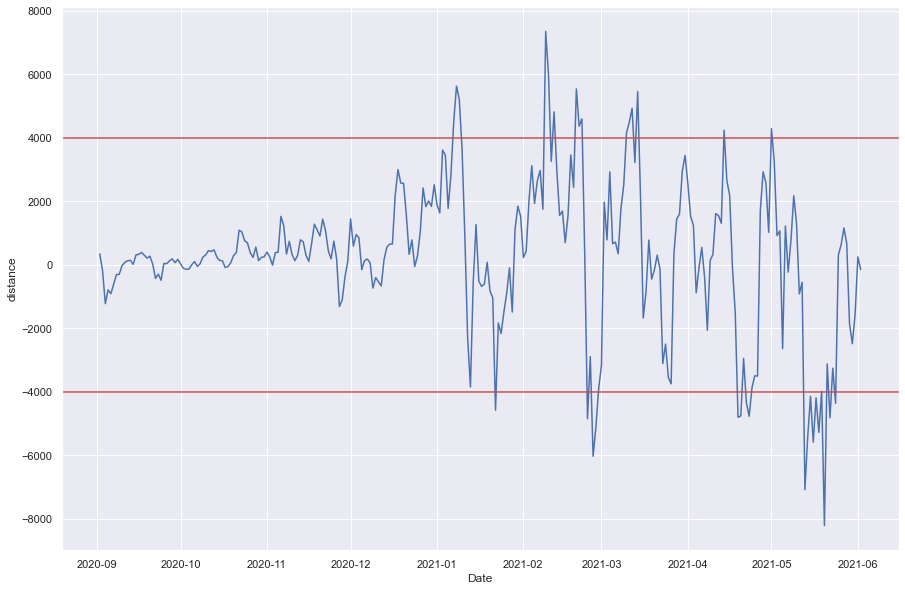

In [7]:
# Plot of fluctation over time.
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=dataMeanReversion['distance'], legend=False)
# Plot the threshold value.
plt.axhline(threshold, color='r')
plt.axhline(-threshold, color='r')
plt.show()

In [8]:
# Position.
dataMeanReversion['position'] = np.where(dataMeanReversion['distance'] > threshold, -1, np.nan)

dataMeanReversion['position'] = np.where(dataMeanReversion['distance'] < -threshold, 1, dataMeanReversion['position'])

dataMeanReversion['position'] = np.where((dataMeanReversion['distance'] * dataMeanReversion['distance'].shift(1)) < 0, 1, dataMeanReversion['position'])

In [9]:
dataMeanReversion['position'] = dataMeanReversion['position'].ffill().fillna(0)

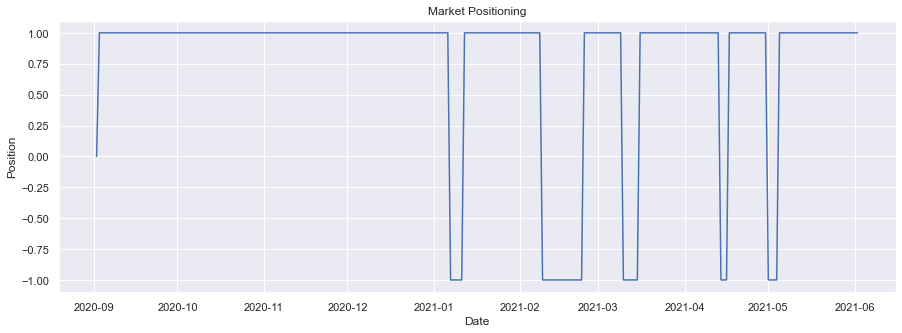

In [10]:
# Plot of market position over time.
plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=dataMeanReversion['position'])
ax.set(xlabel='Date', ylabel='Position', title='Market Positioning')
plt.show()

In [11]:
# Strategy based returns (log scale).
dataMeanReversion['strategy'] = dataMeanReversion['position'].shift(1) * dataMeanReversion['returns']

dataMeanReversion.dropna(inplace=True)

In [12]:
# Cumulative returns over time based on the mean reversion strategy (log scale).
gross_performance_mean_reversion = dataMeanReversion[['returns', 'strategy']].cumsum().apply(np.exp)

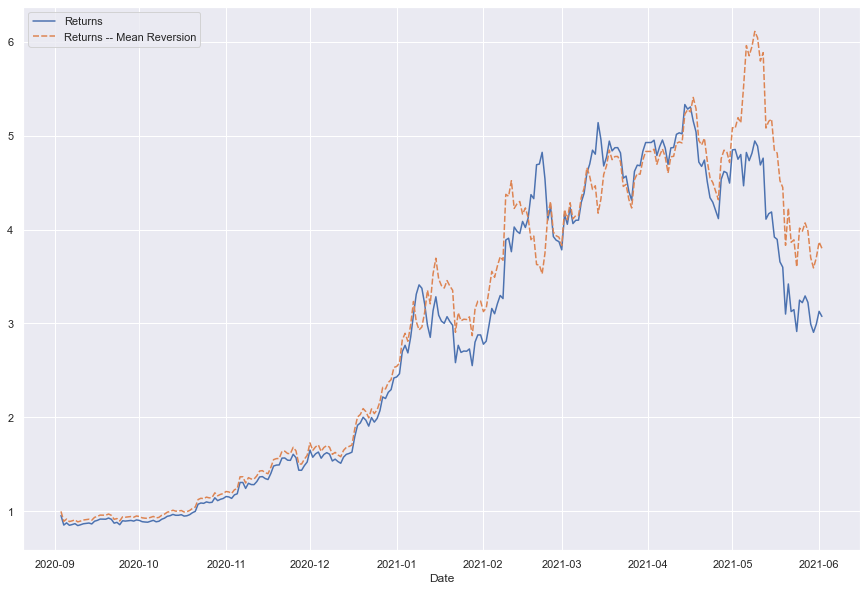

In [13]:
# Plot of cumulative returns based on the mean revrsion strategy over time.
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=gross_performance_mean_reversion, legend=False)
ax.legend(['Returns', 'Returns -- Mean Reversion'])
plt.show()

In [14]:
# Trades executed.
trades_mr = dataMeanReversion['position'].diff().fillna(0) != 0

# Amount invested (US$).
amount_mr = 10000
# Transaction cost (constant) (log scale).
transaction_cost_mr = 0.1/100

# Subtract the transaction cost.
dataMeanReversion['strategy'][trades_mr] -= transaction_cost_mr 

# Cumulative returns (US$).
dataMeanReversion['creturns'] = amount_mr * dataMeanReversion['returns'].cumsum().apply(np.exp)
dataMeanReversion['cstrategy'] = amount_mr * dataMeanReversion['strategy'].cumsum().apply(np.exp)

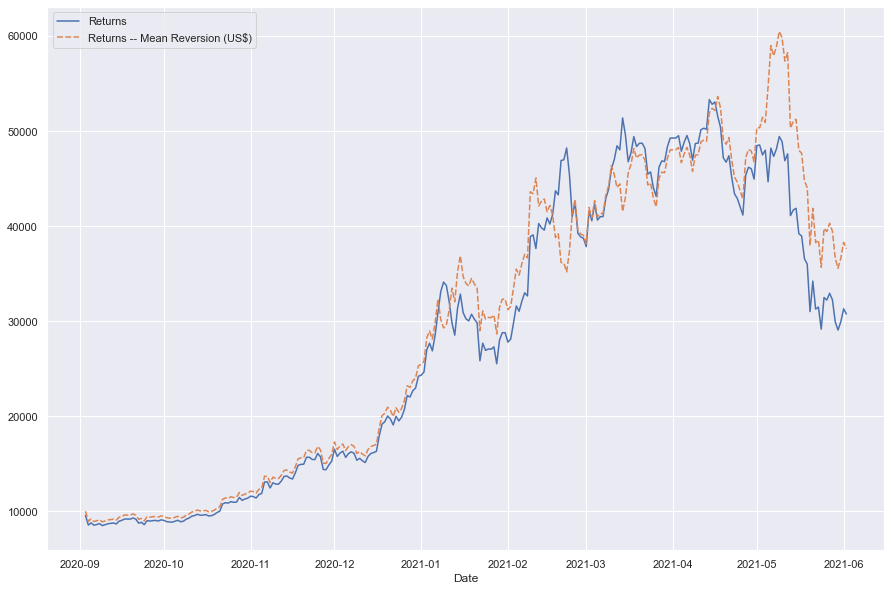

In [15]:
# Plot of cumulative returns.
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=dataMeanReversion[['creturns', 'cstrategy']], legend=False)
ax.legend(['Returns', 'Returns -- Mean Reversion (US$)'])
plt.show()

In [16]:
# Annualized mean returns in regular space.
print(np.exp(dataMeanReversion[['returns', 'strategy']].mean() * 252) - 1)

returns     1.820355
strategy    2.397977
dtype: float64


## Summary

Mean reversion trading tries to capitalize on extreme changes in the pricing of a particular security, assuming that it will revert to its previous state. This theory can be applied to both buying and selling, as it allows a trader to profit from unexpected upswings and to save on abnormal lows.
However, return to a normal pattern is not guaranteed, as unexpected highs or lows could indicate a shift in the norm.

### References

1. [Mean Reversion by James Chen](https://www.investopedia.com/terms/m/meanreversion.asp)